# Seminar 1: Spectrograms and and the Griffin-Lim Algorithm


In this seminar you're going to get your forst taste of working with speech and audio! This seminar is split into two parts. 

### Part 1 - Extracting Speech Representations (5 points)

In part 1 you will learn how to take raw audio (which you can listen to, or even record your own) and convert it into different representations which are useful for speech processing, such as Spectrogram, Mel-Spectrograms and MFCC coefficients. 

You will learn:
* How to implement the Short-Time Fourier Transform
* How to stack a series of shifted STFTs into a Frequence Spectrogram
* How to use the Mel-Scale Filterbank to compress a Frequence Spectrogram into a Mel-Spectrogram
* How to obtain Mel-Frequence Cepstral Coefficients (MFCCs) from a Mel-Spectrogram

### Part 2 - Recovering Audio from Speech Representations (5 points)

In part 2 you will essentially undo what you did in part 1 and convert Mel-Spectrogram and MFCC representations back to audio via the Griffin-Lim Algorithm. Finally, you're going to take everything you have learned and do some voice warping! It's gonna be fun! ....and creepy. Veery veery creepy.

You will learn:
* How to recover a Frequency Spectrogram from a Mel-Spectrogram
* How to recocer Audio from a Frequency Spectrogram via the Griffin-Lim algorithm
* Use the over tools to do some simple voice warping to make yourself sound like an alien or demon!


```

### Submitting results

The results of this task are one artifact:
1. this Jupiter Notebook (`.ipynb`) with completed cells



![img](https://github.com/yandexdataschool/speech_course/raw/main/week_02/stft-scheme.jpg)

## Setup

Here we import all the necessary repos and download the audio samples you will work with in this seminar.

In [3]:
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
import librosa

# !wget https://github.com/yandexdataschool/nlp_course/raw/2019/week10_asr/sample1.wav -O sample1.wav
# !wget https://github.com/yandexdataschool/nlp_course/raw/2019/week10_asr/sample2.wav -O sample2.wav



display(Audio("sample1.wav"))
display(Audio("sample2.wav"))

## Part 1: Extracting Speech Regresentations(10 points)

In the first part of this seminar you will take short audio samples and transforms them into a form which is convenient for further processing, such speech recognition, voice-warping. We will examine two such forms - a Mel-Spectrogram (MelSpec) and a Mel-Frequency Cepstral Coefficients (MFCCs). 





### Theoretical Recap

Sound can be recorded as a series of __amplitudes__ of air-pressure sampled at a certain point at a certainty sample-rate or sample-frequency using a microphone. Typical sampling frequencies can be 16khz, 22Khz or 48kHz. In this seminar we will use samples recorded at 22kHz, which means that __each second of recorded sound will contain 22 thousand (22050 actually) amplitude samples__. Consider the short audio files below:




22050
Length: 3.947392290249433 seconds at sample rate 22050


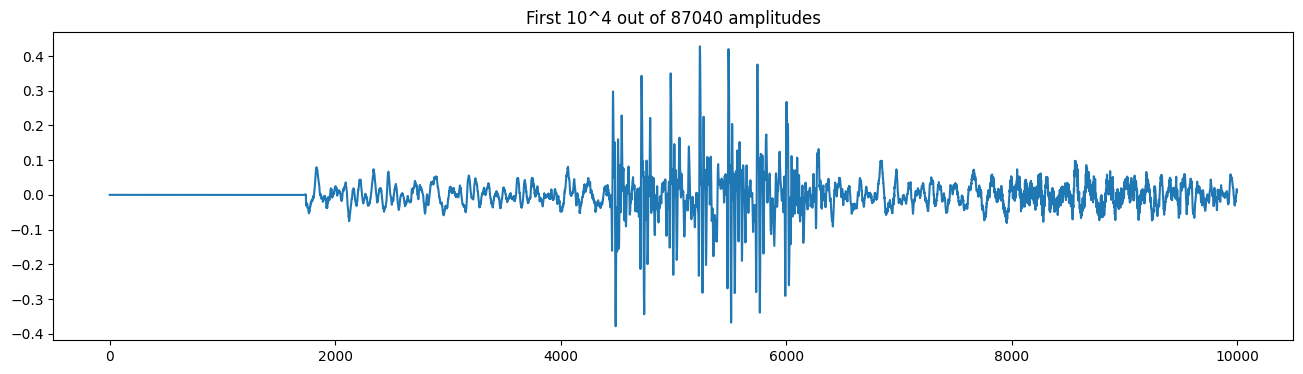

In [4]:
amplitudes, sample_rate = librosa.core.load("sample1.wav")

display(Audio(amplitudes, rate=sample_rate))
print(sample_rate)

print("Length: {} seconds at sample rate {}".format(amplitudes.shape[0] / sample_rate, sample_rate))
plt.figure(figsize=[16, 4])
plt.title("First 10^4 out of {} amplitudes".format(len(amplitudes)))
plt.plot(amplitudes[:10000]);

As you can seem the 4-second audio sample where only __7 words__ are said contains __87040__ amplitude samples! This is extremely difficult to process directly due because there's so many of them! It is far more than a typical sequence length for NLP applications. Hence, we need to compress this information to a more manageable size! 

A typical solution is to use __spectrogram:__ instead of saving thousands of amplitudes, we can perform [Fourier transformation](https://en.wikipedia.org/wiki/Fourier_transform) to find which periodics are prevalent at each point in time. More formally, a spectrogram applies [Short-Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to small overlapping windows of the amplitude time-series:


![img](https://github.com/yandexdataschool/speech_course/raw/main/week_02/stft-scheme.jpg)

Formally, consider an audio sequence $\mathbf{x}_{1:t}$. The ouput of an STFT is __complex valued__! The __absolute value__ of $\text{STFT}(\mathbf{x}_{1:t})$ yields the __amplitudes__ of each frequency in the signal. The __square__ of the absolute value yields the __power__ of each signal. When using STFTs, we will always be using the __power spectrum__:

$$
\mathbf{X}_{1:t} =\ |\text{STFT}(\mathbf{x}_{1:t})|^2
$$

These STFTs are then stacked to produce a Frequency-Spectrogram. Typically, the power in higher frequencies drops exponentially, so a "flatter" Frequency-Power spectrogram is produced by taking the logarithm, which emphasizes the higher frequencies.

$$
\textbf{s}_{\tau} = \log \large[|\text{STFT}(\mathbf{x}_{T\cdot(\tau-1):T\cdot\tau})|^2 \large]
$$
$$
\textbf{S} = \textbf{s}_{1:T}
$$


Here is an example if a spectrogram:

<img src="https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png" width="480px"> 


Although we have compressed the information down in the time-axis, this spectrogram is still too large to process directly along the frequency axis. Typical human speech contains frequencies from 20Hz to 20kHz, so the Power-Frequency spectrogram ranges from 0 to 20000 along the frequency axis - this is still too large to be convenient to work with using tools such as Neural Networks. 

The standard approach is to convert spectrogram into a __mel-spectrogram__ by changing frequencies to [Mel-scal](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). Human hearing exponentially drops in sensitivity with increasing frequency. Thus, we can group together higher frequencies and compress them into 'bins'.  

To do this we compute the Mel-basis $\mathbf{M}$ and matrix-multiply our Power-Frequency Spectrogram via the Mel-basis to get your Mel-Spec:

$$ \textbf{MS} = \mathbf{M} \cdot \textbf{S} $$

For the purposes of this seminar, the Mel-basis can be obtained by called Librosa.

### Short-Time Fourier Transforms and Spectrograms

(87040,)


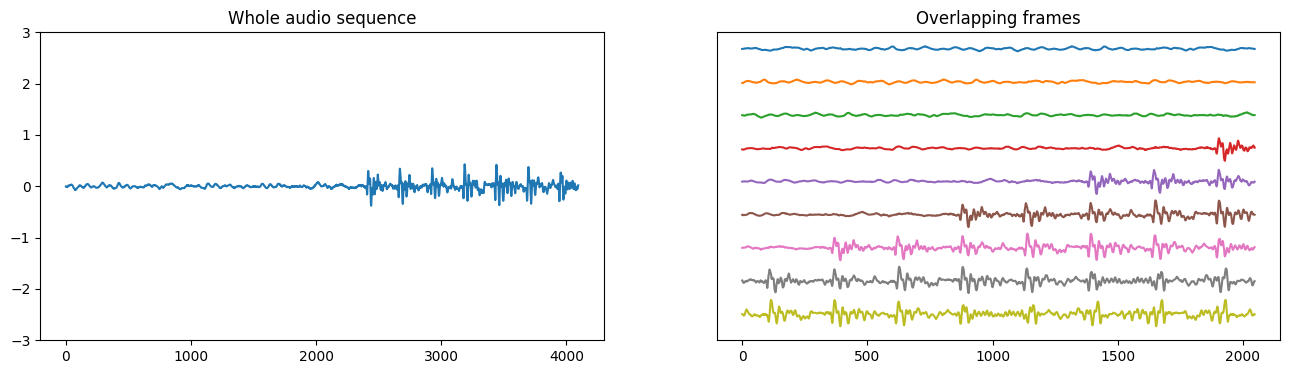

In [5]:
# Some helpers:
# 1. slice time-series into overlapping windows
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # output shape: [window_length, num_windows]

dummy_amps = amplitudes[2048: 6144]
dummy_frames = slice_into_frames(dummy_amps, 2048, 512)
print(amplitudes.shape)

plt.figure(figsize=[16, 4])
plt.subplot(121, title='Whole audio sequence', ylim=[-3, 3])
plt.plot(dummy_amps)

plt.subplot(122, title='Overlapping frames', yticks=[])
for i, frame in enumerate(dummy_frames.T):
    plt.plot(frame + 10 - i);

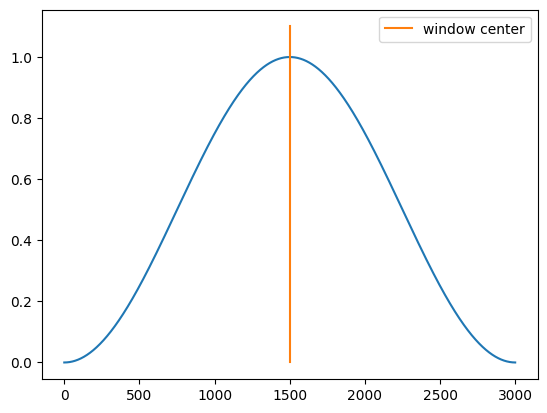

In [6]:
# 2. Weights for window transform. Before performing FFT you can scale amplitudes by a set of weights
# The weights we're gonna use are large in the middle of the window and small on the sides
dummy_window_length = 3000
dummy_weights_window = librosa.core.spectrum.get_window('hann', dummy_window_length, fftbins=True)
plt.plot(dummy_weights_window); plt.plot([1500, 1500], [0, 1.1], label='window center'); plt.legend()

(1501, 1)


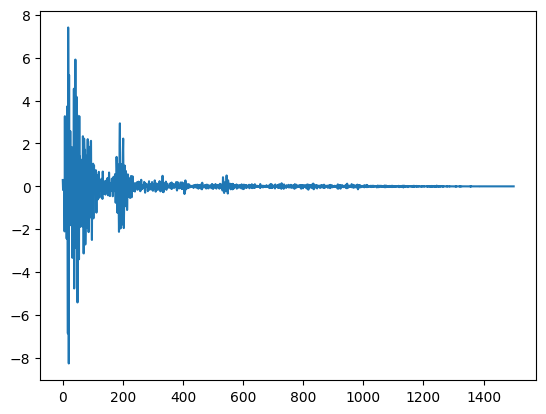

In [7]:
# 3. Fast Fourier Transform in Numpy. Note: this function can process several inputs at once (mind the axis!)
dummy_fft = np.fft.rfft(dummy_amps[:3000, None] * dummy_weights_window[:, None], axis=0)  # complex[sequence_length, num_sequences]
plt.plot(np.real(dummy_fft)[:, 0])
print(dummy_fft.shape)

Okay, now it's time to combine everything into a __S__hort-__T__ime __F__ourier __T__ransform

In [26]:
def get_STFT(amplitudes, window_length=2048, hop_length=512):
    """ Compute short-time Fourier Transform 
    :param amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :returns: mel-spetrogram [n_mels, duration]

    """

    padding = [(0, 0) for _ in range(amplitudes.ndim)]
    padding[-1] = (int(window_length // 2), int(window_length // 2))
    amplitudes = np.pad(amplitudes, padding, mode="constant")
    # slice amplitudes into overlapping frames [window_length, num_frames]
    frames = librosa.util.frame(amplitudes, frame_length=window_length, hop_length=hop_length)

    # get weights for fourier transform, float[window_length] check https://librosa.org/doc/main/generated/librosa.filters.get_window.html
    fft_weights = librosa.filters.get_window("hann", window_length, fftbins=True)

    # apply fourier transfrorm to frames scaled by weights using np.fft.rfft: https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [43]:
# Assess Short-Time Fourier Transform (4 points)

amplitudes1, s1 = librosa.core.load("sample1.wav")
amplitudes2, s2 = librosa.core.load("sample2.wav")

ref1 = librosa.stft(amplitudes1, win_length=2048, hop_length=512)
ref2 = librosa.stft(amplitudes2, win_length=2048, hop_length=512)

print(np.allclose(get_STFT(amplitudes1), ref1, rtol=1e-4, atol=1e-4))
print(np.allclose(get_STFT(amplitudes2), ref2, rtol=1e-4, atol=1e-4))

True
True


In [28]:
def get_spectrogram(amplitudes, window_length=2048, hop_length=512):
    """
    Implement Power Spectrogram as described above.
    :param amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :returns: power-frequency spetrogram [n_freq, duration]
    """
    # Step I: compute Short-Time Fourier Transform
    stft = get_STFT(amplitudes)
    # print(stft.shape)
    # print(window_length // 2 + 1, len(amplitudes) // hop_length + 1)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // hop_length + 1)
    
    # Step II: convert stft to a spectrogram
    spectrogram = np.abs(stft)**2

    return spectrogram

In [44]:
# Assess Power Frequency Spectrogram (1 point)
from librosa.core.spectrum import _spectrogram as magnitude_spectrogram

amplitudes1, s1 = librosa.core.load("sample1.wav")
amplitudes2, s2 = librosa.core.load("sample2.wav")

ref1, _ = magnitude_spectrogram(y=amplitudes1, win_length=2048)
ref2, _ = magnitude_spectrogram(y=amplitudes2, win_length=2048)

print(np.allclose(get_spectrogram(amplitudes1), ref1**2, rtol=1e-4, atol=1e-4))
print(np.allclose(get_spectrogram(amplitudes2), ref2**2, rtol=1e-4, atol=1e-4))

True
True


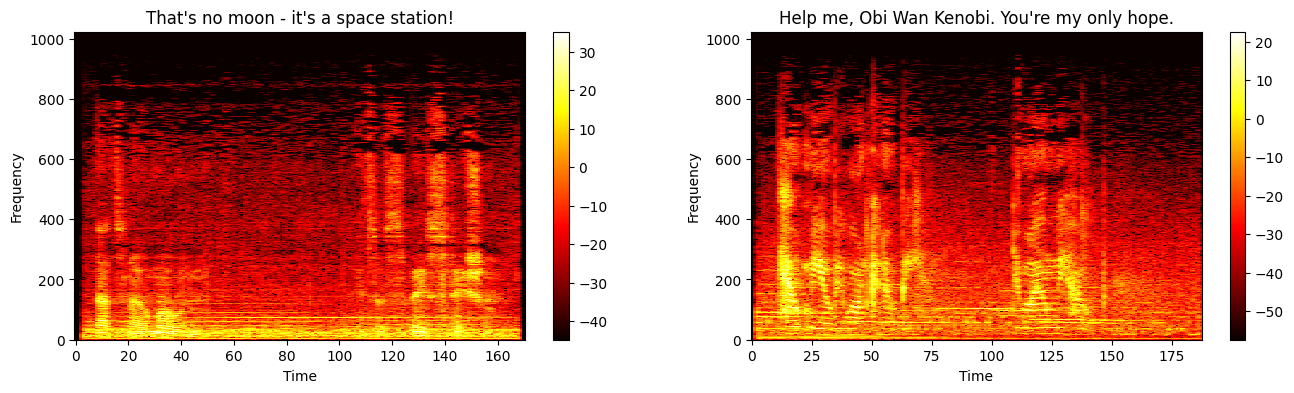

In [30]:
# Now let's examine the Mel-Specs for the two audio samples we have.

plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("That's no moon - it's a space station!"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(get_spectrogram(amplitudes1)),origin='lower', cmap=plt.cm.hot, interpolation='nearest', aspect='auto')
plt.colorbar(use_gridspec=True)

plt.subplot(1, 2, 2)
plt.title("Help me, Obi Wan Kenobi. You're my only hope."); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(get_spectrogram(amplitudes2)),origin='lower', cmap=plt.cm.hot, interpolation='nearest', aspect='auto');
plt.colorbar(use_gridspec=True)

# note that the second spectrogram has higher mean frequency corresponding to the difference in gender

### Mel-Basis and Mel-Spectrograms

C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\1195464883.py:1: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(22050, n_fft=2048, n_mels=128, fmin=1, fmax=8192)


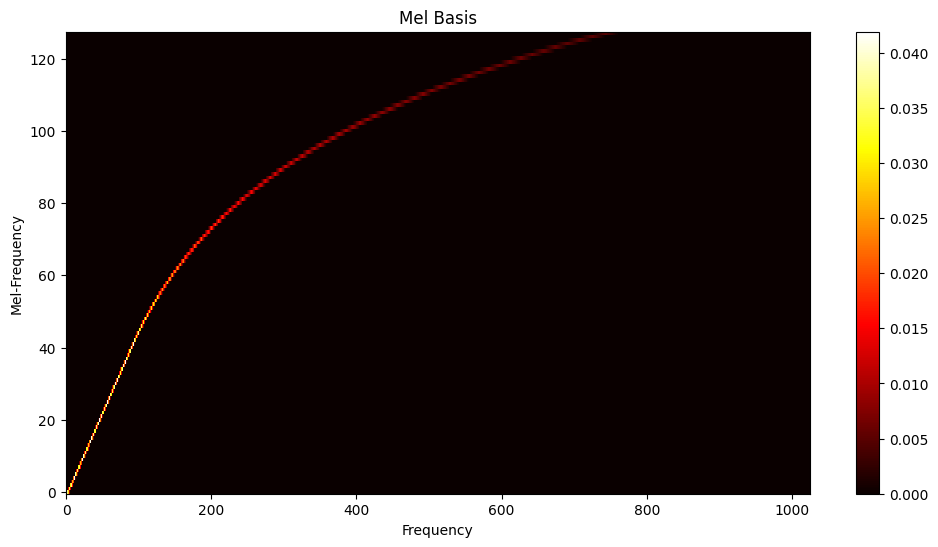

In [31]:
mel_basis = librosa.filters.mel(22050, n_fft=2048, n_mels=128, fmin=1, fmax=8192)

plt.figure(figsize=[12, 6])
plt.title("Mel Basis"); plt.xlabel("Frequency"); plt.ylabel("Mel-Frequency")
plt.imshow(mel_basis,origin='lower', cmap=plt.cm.hot,interpolation='nearest', aspect='auto')
plt.colorbar(use_gridspec=True)


In [32]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
    :param sample rate: num amplitudes per second
    :param n_mels: spectrogram channels
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :param f_min: minimal frequency
    :param f_max: maximal frequency
    :returns: frequency spetrogram [n_mels, duration]
    """
    spectrogram = get_spectrogram(amplitudes)
    
    # Step III: convert spectrogram into Mel basis (multiplying by transformation matrix)
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # -- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.einsum("...ft,mf->...mt", spectrogram, mel_basis, optimize=True)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // hop_length + 1)
    
    return mel_spectrogram

In [45]:
# Evaluate the mel spectrograms against the librosa implementation. (3 points)

amplitudes1, s1 = librosa.core.load("sample1.wav")
amplitudes2, s2 = librosa.core.load("sample2.wav")

ref1 = librosa.feature.melspectrogram(amplitudes1, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
ref2 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)

print(np.allclose(get_melspectrogram(amplitudes1), ref1, rtol=1e-4, atol=1e-4))
print(np.allclose(get_melspectrogram(amplitudes2), ref2, rtol=1e-4, atol=1e-4))

C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\680047360.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ref1 = librosa.feature.melspectrogram(amplitudes1, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\680047360.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00013178 0.00014526 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ref2 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)


True
True


C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2643114629.py:17: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,


C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2643114629.py:17: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,


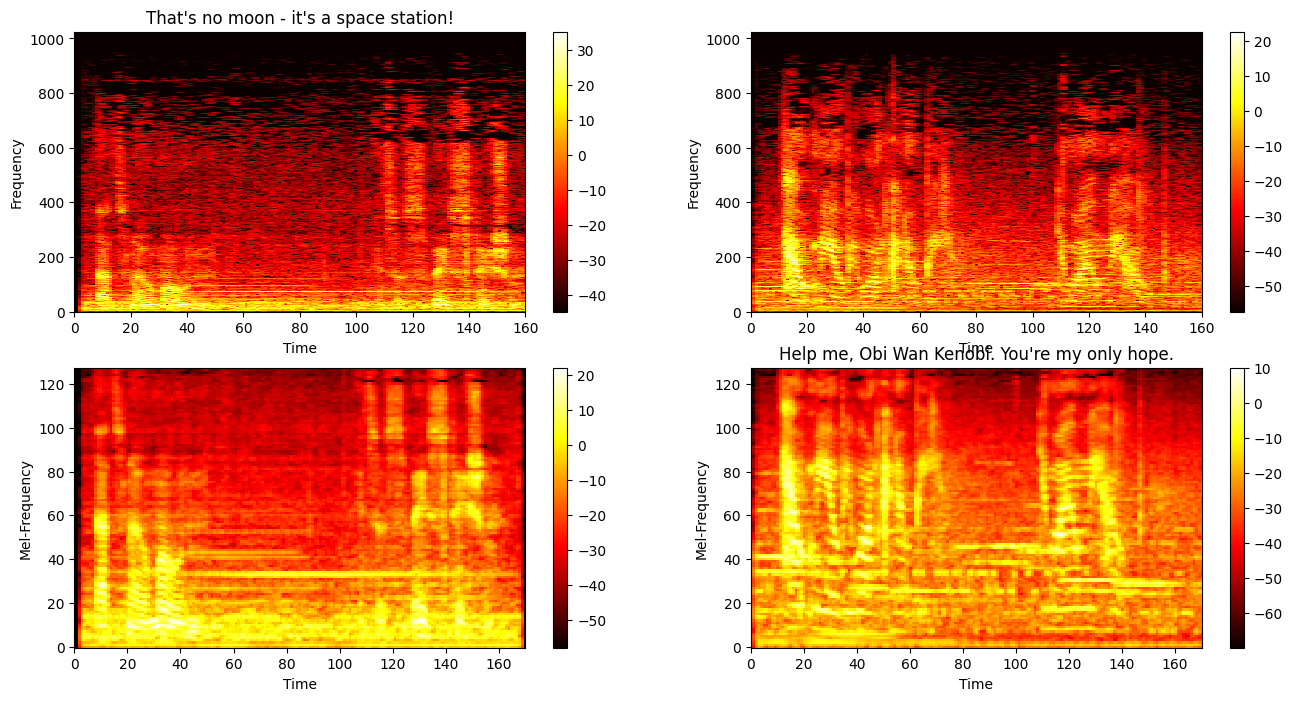

In [34]:
# Now let's examine the Mel-Specs for the two audio samples we have.

plt.figure(figsize=[16, 8])

plt.subplot(2, 2, 1)
plt.title("That's no moon - it's a space station!"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(get_spectrogram(amplitudes1)),origin='lower', cmap=plt.cm.hot, interpolation='nearest', aspect='auto')
plt.xlim(0,160)
plt.colorbar(use_gridspec=True)

plt.subplot(2, 2, 2)
plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(get_spectrogram(amplitudes2)),origin='lower', cmap=plt.cm.hot, interpolation='nearest', aspect='auto');
plt.xlim(0,160)
plt.colorbar(use_gridspec=True)


plt.subplot(2, 2, 3)
plt.xlabel("Time"); plt.ylabel("Mel-Frequency")
plt.imshow(librosa.power_to_db(get_melspectrogram(amplitudes1)),origin='lower', cmap=plt.cm.hot,interpolation='nearest', aspect='auto')
plt.xlim(0,170)
plt.colorbar(use_gridspec=True)

plt.subplot(2, 2, 4)
plt.title("Help me, Obi Wan Kenobi. You're my only hope."); plt.xlabel("Time"); plt.ylabel("Mel-Frequency")
plt.imshow(librosa.power_to_db(get_melspectrogram(amplitudes2)),origin='lower', cmap=plt.cm.hot,  interpolation='nearest', aspect='auto');
plt.xlim(0,170)
plt.colorbar(use_gridspec=True)

# note that the second spectrogram has higher mean frequency corresponding to the difference in gender

### MFCC Coefficients

In [35]:
def get_MFCC(amplitudes, n_mfcc=128, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
    :param sample rate: num amplitudes per second
    :param n_mfcc: number of MFCC coefficients to keep
    :param n_mels: number of Mel channels
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :param f_min: minimal frequency
    :param f_max: maximal frequency
    :returns: frequency spetrogram [n_mels, duration]
    """
    # Get Power Mel-Spec 
    
    power_mel_spec = get_melspectrogram(amplitudes)

    # Get Log Power Mel-SPec in db: 10 * log10(S) check https://librosa.org/doc/main/generated/librosa.power_to_db.html
    db_mel_spec = librosa.power_to_db(power_mel_spec)
   

    # Apply Discrete Cosin Transformation
    #HINT: use sscipy.fftpack.dct(..., type=2, norm="ortho")
    return sp.fftpack.dct(db_mel_spec, axis=-2, type=2, norm="ortho")[..., :n_mfcc, :]

In [36]:
# Evaluate the mel spectrograms against the librosa implementation. (3 points)

amplitudes1, s1 = librosa.core.load("sample1.wav")
amplitudes2, s2 = librosa.core.load("sample2.wav")

ref1 = librosa.feature.mfcc(amplitudes1, sr=sample_rate, n_mfcc=128, fmin=1, fmax=8192)
ref2 = librosa.feature.mfcc(amplitudes2, sr=sample_rate, n_mfcc=128, fmin=1, fmax=8192)

print(np.allclose(get_MFCC(amplitudes1), ref1, rtol=1e-4, atol=1e-4))
print(np.allclose(get_MFCC(amplitudes2), ref2, rtol=1e-4, atol=1e-4))

True
True


C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2843920059.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ref1 = librosa.feature.mfcc(amplitudes1, sr=sample_rate, n_mfcc=128, fmin=1, fmax=8192)
C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2843920059.py:7: FutureWarning: Pass y=[0.         0.         0.         ... 0.00013178 0.00014526 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ref2 = librosa.feature.mfcc(amplitudes2, sr=sample_rate, n_mfcc=128, fmin=1, fmax=8192)
C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2643114629.py:17: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,


C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2643114629.py:17: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,


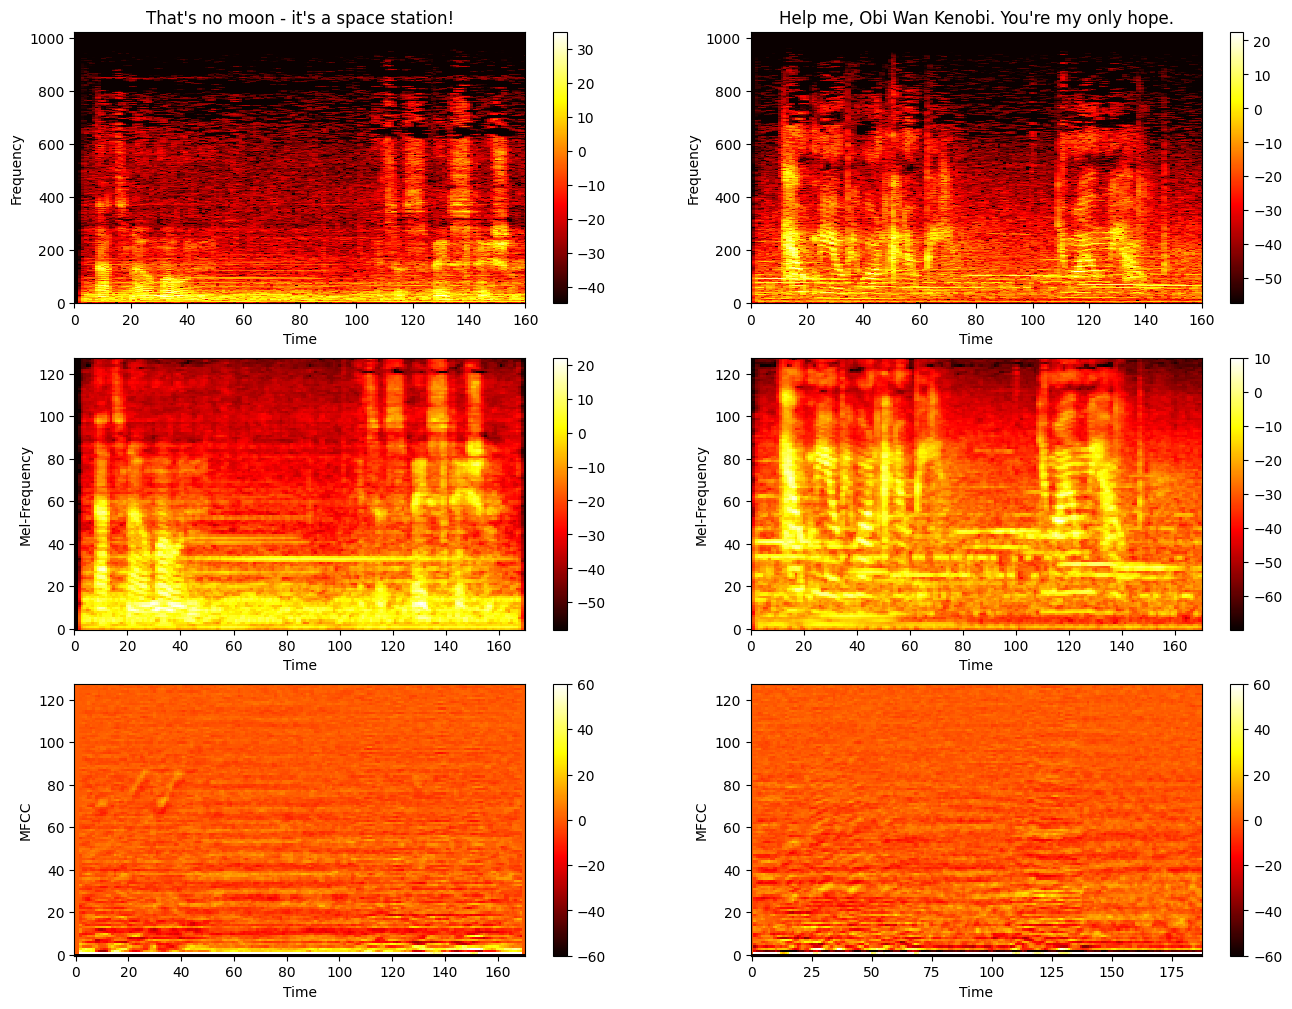

In [37]:
# Now let's examine the Mel-Specs for the two audio samples we have.


# Now let's examine the Mel-Specs for the two audio samples we have.

plt.figure(figsize=[16, 12])

plt.subplot(3, 2, 1)
plt.title("That's no moon - it's a space station!"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(get_spectrogram(amplitudes1)),origin='lower', cmap=plt.cm.hot, interpolation='nearest', aspect='auto')
plt.xlim(0,160)
plt.colorbar(use_gridspec=True)

plt.subplot(3, 2, 2)
plt.title("Help me, Obi Wan Kenobi. You're my only hope.");  plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(get_spectrogram(amplitudes2)),origin='lower', cmap=plt.cm.hot, interpolation='nearest', aspect='auto');
plt.xlim(0,160)
plt.colorbar(use_gridspec=True)


plt.subplot(3, 2, 3)
plt.xlabel("Time"); plt.ylabel("Mel-Frequency")
plt.imshow(librosa.power_to_db(get_melspectrogram(amplitudes1)),origin='lower', cmap=plt.cm.hot,interpolation='nearest', aspect='auto')
plt.xlim(0,170)
plt.colorbar(use_gridspec=True)

plt.subplot(3, 2, 4)
plt.xlabel("Time"); plt.ylabel("Mel-Frequency")
plt.imshow(librosa.power_to_db(get_melspectrogram(amplitudes2)),origin='lower', cmap=plt.cm.hot,  interpolation='nearest', aspect='auto');
plt.xlim(0,170)
plt.colorbar(use_gridspec=True)

plt.subplot(3, 2, 5)
plt.xlabel("Time"); plt.ylabel("MFCC")
plt.imshow(get_MFCC(amplitudes1, n_mfcc=128),origin='lower', vmin=-60, vmax=60,cmap=plt.cm.hot,interpolation='nearest', aspect='auto')
plt.colorbar(use_gridspec=True)

plt.subplot(3, 2, 6)
plt.xlabel("Time"); plt.ylabel("MFCC")
plt.imshow(get_MFCC(amplitudes2, n_mfcc=128),origin='lower', vmin=-60, vmax=60, cmap=plt.cm.hot,interpolation='nearest', aspect='auto');
plt.colorbar(use_gridspec=True)

## Part 2 - From Representations Back to Audio via the Griffin-Lim Algorithm - 10 Points

In this task you are going to reconstruct the original audio signal from a Mel-Spectrogram using a simple __Vocoder__ implemented using the __Griffin-Lim Algorithm (GLA)__ . Essentially you are running the pipeline from Part 1 in reverse. Note, we won't be restoring audio from MFCC as they have lost too much information. 

Thus, the task is split into several parts:

1. Recover a Power-Frequency Spectrogram from a Mel-Spectrogram
2. Implement the Inverse STFT.
3. Implement the GLA algorithm to reconstruct the phase in your spectrogram.


### From Mel-Spectrogram to Frequency Spectrogram

In [38]:
# Inverse MFCC implemeted for you for comparision
def inv_MFCC(MFCCs):
    """
    Implement mel-spectrogram as described above.
    :param MFCCs: array [n_mfcc, duration]
    :returns: Mel-Spectrogram [n_mfcc, duration]
    """

    db_spec = sp.fftpack.idct(MFCCs, type=2, n=None, axis=0, norm='ortho')

    mel_spectrogram = librosa.db_to_power(db_spec)
    return mel_spectrogram

In [59]:
# STEP 1: Reconstruct your Power-Frequency Spectrogram from the Mel-Spectrogram
def inv_mel_spectrogram(mel_spectrogram, sample_rate=22050, n_mels=None,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement Recovers a Power Frequency Spectrogram from a Power Mel-Frequency Spectrgram.
    :param mel_spectrogram: array [n_mels, duration]
    :param sample rate: num amplitudes per second
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :param f_min: minimal frequency
    :param f_max: maximal frequency
    :returns: frequency spetrogram array [n_mels, duration]
    """
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=mel_spectrogram.shape[0], fmin=fmin, fmax=fmax)                       
    
    inv_mel_basis =  librosa.util.nnls(mel_basis, mel_spectrogram)
    spectrogram = get_spectrogram(inv_mel_basis)
    
    return spectrogram

In [60]:
# Assess Inverse Mel-Spec (2 Points)

amplitudes1, s1 = librosa.core.load("sample1.wav")
amplitudes2, s2 = librosa.core.load("sample2.wav")

res1 = inv_mel_spectrogram(get_melspectrogram(amplitudes1, window_length=2048, hop_length=512), sample_rate=s1)
res2 = inv_mel_spectrogram(get_melspectrogram(amplitudes2, window_length=2048, hop_length=512), sample_rate=s2)

ref1 = np.loadtxt('spec_sample1.txt')
ref2 = np.loadtxt('spec_sample2.txt')


print(np.allclose(res1, ref1, rtol=1e-4, atol=1e-4))
print(np.allclose(res2, ref2, rtol=1e-4, atol=1e-3))

C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2643114629.py:17: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
C:\Users\Sid\AppData\Local\Temp\ipykernel_14564\2656976961.py:14: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,


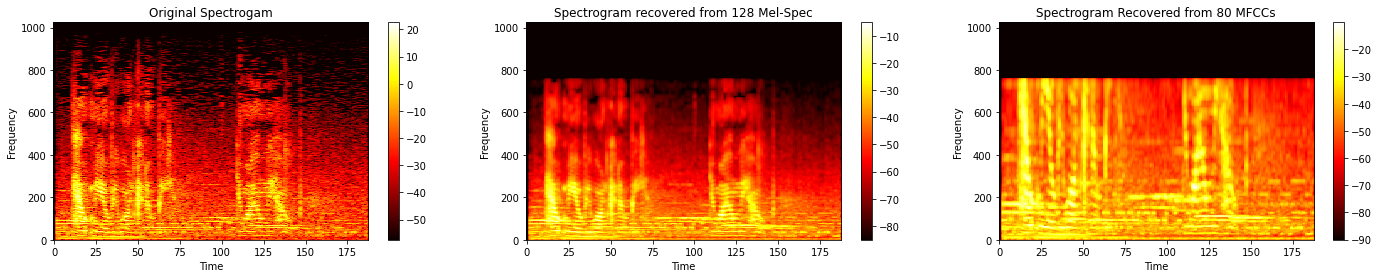

In [ ]:
amplitudes, sample_rate = librosa.core.load("sample2.wav")

true_spec = get_spectrogram(amplitudes)
mel_spec = get_melspectrogram(amplitudes, window_length=2048, hop_length=512)
MFCCs = get_MFCC(amplitudes, n_mfcc=80)

#Convert Back to Spec
rec_mel_spec = inv_MFCC(MFCCs)
rec_spec = inv_mel_spectrogram(mel_spec, window_length=2048, hop_length=512)
rec_mfcc_spec = inv_mel_spectrogram(rec_mel_spec, n_mels=80)

plt.figure(figsize=[24, 4])
plt.subplot(1, 3, 1)
plt.title("Original Spectrogam"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(true_spec),origin='lower',interpolation='nearest', cmap=plt.cm.hot, aspect='auto')
plt.colorbar(use_gridspec=True)

plt.subplot(1, 3, 2)
plt.title("Spectrogram recovered from 128 Mel-Spec"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(rec_spec),origin='lower',interpolation='nearest', cmap=plt.cm.hot, aspect='auto')
plt.colorbar(use_gridspec=True)

plt.subplot(1, 3, 3)
plt.title("Spectrogram Recovered from 80 MFCCs"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(librosa.power_to_db(rec_mfcc_spec),origin='lower',interpolation='nearest', cmap=plt.cm.hot, aspect='auto')
plt.colorbar(use_gridspec=True)

### The Griffin-Lim Algorithm

Recall that when constructing a spectrogram, which just contains the STFT magnitudes, the **phase information** is thrown away. In order to reconstruct the original signal by taking an inverse Fourier Transform we need to somehow reconstruct this phase information. 

Obviously, doing so from a **single** acoustic frame is information is impossible - that information is gone. However the spectrogram (a sequence of acoustic frames) is **redundant** because the acoustic frames are computed from **overlapping windows** and therefore **jointly** contain information about phase. 

One way to make use of this redundancy to recover phase information is via the Griffin-Lim Algorithm (GLA). Put simply, the GLA algorithm. It does this being enforcing the **consistency** of a spectrogram by iterating two projections. We construct a complex signal in frequency space and use the mangitude from the spectrogram frames. We take the inverse Fourier Transform of this signal, then take the Fourier transorm of the signal and obtain updated phase information and distorted magnitudes, which are replaced with the original spectrogram magnitudes. This is repeated until the original and obtained spectrogram magnitudes match and are consistent with reach other. Note, however, that GLA is based only on the consistency and does not take any prior knowledge about the target signal into account.

Although GLA has been widely utilized because of its simplicity, GLA often involves many iterations until it converges to a certain spectrogram and results in low reconstruction quality. This is because the cost function only requires the consistency, and the characteristics of the target signal are not taken into account.

(1501, 1)


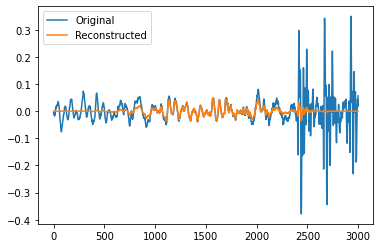

In [ ]:
# Lets examine how to take an inverse FFT
dummy_window_length = 3000
dummy_weights_window = librosa.core.spectrum.get_window('hann', dummy_window_length, fftbins=True)

dummy_fft = np.fft.rfft(dummy_amps[:3000, None] * dummy_weights_window[:, None], axis=0)  # complex[sequence_length, num_sequences]
print(dummy_fft.shape)
rec_dummy_amps = dummy_weights_window*np.real(np.fft.irfft(dummy_fft[:,0]))
plt.plot(dummy_amps[:3000])
plt.plot(rec_dummy_amps[:3000])
plt.legend(['Original', 'Reconstructed'])

In [ ]:
# Step II: Reconstruct amplitude samples from STFT
def get_iSTFT(spectrogram, window_length=2048, hop_length=512):
    """ 
    Compute inverse short-time Fourier Transform
    :param spectrogram: complex array [n_frequencies, duration]
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :returns amplitudes: float [num_amplitudes], time-series of sound amplitude
    """

    assert spectrogram.dtype == np.complex
    # get weights for fourier transform, float[window_length]
    window = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    time_slices = spectrogram.shape[1]

    # how many samples was at the start + window size
    len_samples = <Your code here>
    
    # apply fourier transfrorm to frames scaled by weights
    transformed = np.zeros(len_samples)

    for win, hop in enumerate(range(0, len_samples - window_length, hop_length)):
        transformed[hop:hop+window_length] += <Your code here>
    
    wss = librosa.filters.window_sumsquare(window='hann', n_frames=time_slices, hop_length=hop_length)

    transformed /= wss 

    # Trim the array to correct length from both sides
    x = <Your code here>
    return x

In [ ]:
# Assess Short-Time Fourier Transform (4 points)

amplitudes1, s1 = librosa.core.load("./sample1.wav")
amplitudes2, s2 = librosa.core.load("./sample2.wav")

ref1 = librosa.istft(librosa.stft(amplitudes1, win_length=2048, hop_length=512),  win_length=2048, hop_length=512, center=True)
ref2 = librosa.istft(librosa.stft(amplitudes2, win_length=2048, hop_length=512),  win_length=2048, hop_length=512, center=True)


res1 = get_iSTFT(get_STFT(amplitudes1))
res2 = get_iSTFT(get_STFT(amplitudes2))

assert np.allclose(res1, ref1, rtol=1e-2, atol=1e-2)
assert np.allclose(res2, ref2, rtol=1e-2, atol=1e-2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
# Step III: Implement the Griffin-Lim Algorithm
def griffin_lim(power_spectrogram, window_size, hop_length, iterations, seed=1, verbose=True):
    """Reconstruct an audio signal from a magnitude spectrogram.
    Given a power spectrogram as input, reconstruct
    the audio signal and return it using the Griffin-Lim algorithm from the paper:
    "Signal estimation from modified short-time fourier transform" by Griffin and Lim,
    in IEEE transactions on Acoustics, Speech, and Signal Processing. Vol ASSP-32, No. 2, April 1984.

    Args:
        :param spectrogram: array [n_frequencies, duration] - your POWER spectrogram
        :param window_length: length of a patch to which you apply FFT
        :param hop_length: interval between consecutive windows
        : param iterations: int -  Number of iterations for the Griffin-Lim algorithm. Typically a 50
    Returns:
         amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
        
    Compute inverse short-time Fourier Transform

    """
    
    time_slices = power_spectrogram.shape[1]
    len_samples = int(time_slices*hop_length-hop_length)
    
    # Obtain STFT magnitude from Spectrogram
    magnitude_spectrogram = <Your code here>
    
    # Initialize the reconstructed signal to noise.
    np.random.seed(seed)
    x_reconstruct = np.random.randn(len_samples)
    old_diff = np.infty
    for n in range(iterations):
        # Get the SFTF of a random signal
        reconstruction_spectrogram = <Your code here>
        
        # Obtain the angle part of random STFT. Hint: unit np.angle
        reconstruction_angle = <Your code here>

        # Discard magnitude part of the reconstruction and use the supplied magnitude spectrogram instead.
        proposal_spectrogram = magnitude_spectrogram * np.exp(1j*reconstruction_angle)
        assert proposal_spectrogram.dtype == np.complex

        # Save previous construction
        prev_x = <Your code here>
        
        # Reconstruct signal
        x_reconstruct = <Your code here>
        
        # Measure RMSE
        diff = np.sqrt(sum((x_reconstruct - prev_x)**2)/x_reconstruct.size)
        if verbose:
            # HINT: This should decrease over multiple iterations. If its not, your code doesn't work right!
            # Use this to debug your code! Use verbose for testing!
            print('Reconstruction iteration: {}/{} RMSE: {} '.format(n, iterations, diff))
            assert diff < old_diff
        olf_diff = diff
    return x_reconstruct

In [ ]:
# Reconstruct audio using original Spectrogram
rec_amplitudes1 = griffin_lim(true_spec, 2048, 512, 1, verbose=False)
display(Audio(rec_amplitudes1, rate=sample_rate))
rec_amplitudes2 = griffin_lim(true_spec, 2048, 512, 50, verbose=False)
display(Audio(rec_amplitudes2, rate=sample_rate))

# Reconstruct audio from 128-Mel Mel-Spectrogram
rec_amplitudes3 = griffin_lim(rec_spec, 2048, 512, 1, verbose=False)
display(Audio(rec_amplitudes3, rate=sample_rate))
rec_amplitudes4 = griffin_lim(rec_spec, 2048, 512, 50, verbose=False)
display(Audio(rec_amplitudes4, rate=sample_rate))

# Reconstruct audio from 80-dim MFCCs
rec_amplitudes3 = griffin_lim(rec_mfcc_spec, 2048, 512, 1, verbose=False)
display(Audio(rec_amplitudes3, rate=sample_rate))
rec_amplitudes4 = griffin_lim(rec_mfcc_spec, 2048, 512, 50, verbose=False)
display(Audio(rec_amplitudes4, rate=sample_rate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykern

In [ ]:
# THIS IS AN EXAMPLE OF WHAT YOU ARE SUPPOSED TO GET
# Remember to apply sqrt to spectrogram to get magnitude, note power here.

# Let's try this on a real spectrogram
ref_amplitudes1 = librosa.griffinlim(np.sqrt(true_spec), n_iter=1, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes1, rate=sample_rate))
ref_amplitudes2 = librosa.griffinlim(np.sqrt(true_spec), n_iter=50, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes2, rate=sample_rate))

# Not let's try this on a reconstructed spectrogram
ref_amplitudes3 = librosa.griffinlim(np.sqrt(rec_spec), n_iter=1, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes3, rate=sample_rate))
ref_amplitudes4 = librosa.griffinlim(np.sqrt(rec_spec), n_iter=50, hop_length=512, win_length=2048)
display(Audio(ref_amplitudes4, rate=sample_rate))

### Simple Voice Warping 

In this part we're going to show a simple Voice Warping system by first converting an audio sample into a Mel-Spectrogram and modify the spectrogram. Once we have modified the Mel-Spec appropriately, we will recover the audio from the modified spectrogram via the Griffin-Lim Algorithm.

Some of the transformations you can do are the following:
* Dropout high or low frequencies to evaluate the robustness of the Spectrogram.
* Modify __pitch__ by rotating the values of the Mel-Spec channels up / down.
* Modify your voice by flipping the Mel-Spec vertically
* Time reverse your voice by flipping the Mel-Spec horizontally. 
* If you want to go full-on Lovecraftian Chaos God, flip the Mel-Spec diagonally.
* Time reverse only the even channels, keeping odd channels time-forward. 




In [ ]:
def synthesize(mel_spec, sample_rate):
  rec_spec = inv_mel_spectrogram(mel_spec, window_length=2048, hop_length=512)

  rec_amplitudes = griffin_lim(rec_spec, 2048, 512, 50, verbose=False)
  display(Audio(rec_amplitudes, rate=sample_rate))

In [ ]:
amplitudes, sample_rate = librosa.core.load("sample1.wav")
mel_spec = get_melspectrogram(amplitudes, window_length=2048, hop_length=512)

# Here you can modify your Mel-Spectrogram. Let your twisted imagination fly wild here !!!


# Pitch up (1 point)
warp_mel_spec = mel_spec
warp_mel_spec[10:124,:] = mel_spec[0:114,:]
warp_mel_spec[0:10,:] = 0
synthesize(warp_mel_spec, sample_rate)

# Pitch down (1 point)
warp_mel_spec = mel_spec
warp_mel_spec[0:114,:] = mel_spec[10:124,:]
warp_mel_spec[114:124,:]=0
synthesize(warp_mel_spec, sample_rate)

#Time reverse (for fun)
warp_mel_spec = np.zeros_like(mel_spec) 
warp_mel_spec = mel_spec[:,::-1]
synthesize(warp_mel_spec, sample_rate)

# Trippy Shit
warp_mel_spec = np.zeros_like(mel_spec) 
warp_mel_spec[:64,:] = mel_spec[:64,:]
warp_mel_spec[64:,:] = mel_spec[:64,:]
synthesize(warp_mel_spec, sample_rate)

# Aliens are here
warp_mel_spec = mel_spec[:,:] 
warp_mel_spec = mel_spec[::-1,:] 
synthesize(warp_mel_spec, sample_rate)

# Say hello to your friendly neighborhood Lovecraftian Horror
warp_mel_spec = mel_spec[:,:] 
warp_mel_spec = mel_spec[::-1,::-1] 
synthesize(warp_mel_spec, sample_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
